In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.utils.data as Data
import matplotlib.pyplot as plt

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
torch.set_num_threads(2)

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import os.path as osp
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms


ROOT_PATH = '/home/jiahao/code/SPH6004/mimiciv_aki/'


class ISIC(Dataset):

    def __init__(self, setname):
        csv_path = osp.join(ROOT_PATH, setname + '.npy')
        data = np.load(csv_path)
        
        self.data = data[:,0]
        label = data[:,1]
        label_tensor = torch.from_numpy(label.astype(float))
        self.label = label_tensor.tolist()
#         self.label = torch.from_numpy(label.astype(float))
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        data, label = self.data[i], self.label[i]
        data_tensor = torch.tensor(data)
        label = torch.tensor(label)
        return data_tensor, label

In [4]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    """

    def __init__(self, dataset, indices=None, num_samples=None):

        # if indices is not provided,
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset)))             if indices is None else indices

        # if num_samples is not provided,
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices)             if num_samples is None else num_samples

        # distribution of classes in the dataset
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1

        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        dataset_type = type(dataset)
        if dataset_type is torchvision.datasets.MNIST:
            return dataset.train_labels[idx].item()
        elif dataset_type is torchvision.datasets.ImageFolder:
            return dataset.imgs[idx][1]
        else:
            return dataset.label[idx]

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [5]:
trainset = ISIC('train_data_window_7')
valset = ISIC('test_data_window_7')

In [6]:
from torch.utils.data import DataLoader
import torchvision
# n_train = len(dataset)
# split = n_train // 8
# trainset, valset = torch.utils.data.random_split(dataset, [n_train-split, split])
train_loader = DataLoader(dataset=trainset, sampler=ImbalancedDatasetSampler(trainset),
                              num_workers=4,batch_size=1024,pin_memory=True)
test_loader  = DataLoader(dataset=valset, shuffle=True,
                              num_workers=0,batch_size=1024,pin_memory=True)

In [7]:
print(len(test_loader))

359


In [8]:
data,label = next(iter(train_loader))
print(data.shape)

torch.Size([1024, 7, 26])


In [9]:
print(label.shape)

torch.Size([1024])


In [10]:
import torch
import torch.nn as nn
from typing import Any
class AlexNet(nn.Module):

    def __init__(self, in_class=3,num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        self.embedding = nn.Conv2d(in_class,3,kernel_size=1)
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(True),
#             torch.nn.MaxPool2d(2,2,0),
            
            torch.nn.Conv2d(64, 64, 3, 1, 1, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(True),
#             torch.nn.MaxPool2d(2,2,0),
            
            torch.nn.Conv2d(64, 64, 3, 1, 1, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(True),
#             torch.nn.MaxPool2d(2,2,0),
            
            torch.nn.Conv2d(64, 64, 3, 1, 1, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(True),
#             torch.nn.MaxPool2d(2,2,0),
            
            
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(64, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [11]:
model = AlexNet(7,1)

In [12]:
F = torch.nn.Sigmoid()
def train(epoch):
    model.train()
    loss_sum = 0
    acc_sum = 0
    model.train()
    times = time.time()
    nb_classes = 2
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    
    
    for i ,(images,labels) in enumerate(train_loader):
        
        images = Variable(images.unsqueeze(3).float().cuda())

        labels = Variable(labels.view(-1,1).cuda()).float()
#         labels = Variable(labels.cuda())

                # Forward + Backward + Optimize
        optimizer.zero_grad()
        
        results = model(images)
        outputs = results

        loss = criterion(outputs,labels)
        result = F(outputs)
        predicted = (result.data>0.5).float()
        #             total += a.size(0)
        #             correct += (predicted == a.data).sum()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

        acc = confusion_matrix.diag() / confusion_matrix.sum(1)
        acc_non = acc[0]
        acc_in = acc[1]
        mean_acc = torch.mean(acc)
        
        loss.backward()
        optimizer.step()

        # record the loss
        iter_loss = loss.data.item()      
        loss_sum += float(iter_loss)
        write_loss.add_scalar('epoch/loss', iter_loss, epoch*len(train_loader) + i)
        
        
        if (i+1) % 10 == 0:
                print("Epoch [%d/%d], Iter [%d/%d] Loss: %.4f Acc: %d %%" %(epoch+1, total_epoch, i+1, len(train_loader),
                                                                            loss.data.item(),100*float(mean_acc)))

    return  float(loss_sum)/len(train_loader), float(acc_non),float(acc_in)
    
    


def test(epoch):

    model.eval()
    correct = 0
    total = 0
    loss_sum_t = 0
    nb_classes = 2
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for images,labels in test_loader:
        
            images = Variable(images.unsqueeze(3).float().cuda())
            a = labels
            a = Variable(a.view(-1,1).cuda()).float()
            
            results = model(images)
            outputs = results
            outputs = F(outputs)
            loss_test = criterion(results, a)
            iter_loss_t = loss_test.data.item()
            loss_sum_t += float(iter_loss_t)
            predicted = (outputs.data>0.5).float()
        #             total += a.size(0)
        #             correct += (predicted == a.data).sum()
            for t, p in zip(a.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        acc = confusion_matrix.diag() / confusion_matrix.sum(1)
        acc_non = acc[0]
        acc_in = acc[1]
        mean_acc = torch.mean(acc)


    print('Accuracy of the model on the neg seq: %d %%' % (100 * float(acc_non)))
    print('Accuracy of the model on the pos seq: %d %%' % (100*float(acc_in)))
    return float(acc_non), float(acc_in),float(loss_sum_t) / len(test_loader)

In [13]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        save_filename_c = 'conv4-3-max-acc.pt'
        save_path_c = os.path.join(save_dir, save_filename_c)
        torch.save(model.state_dict(), save_path_c)
        self.val_loss_min = val_loss

In [14]:
from torch.optim.lr_scheduler import StepLR
from tensorboardX import SummaryWriter
LR = 0.1
total_epoch = 100
optimizer = torch.optim.Adam(model.parameters(),lr=LR)
criterion = nn.BCEWithLogitsLoss().cuda()
model.cuda()
classes = ('aki_neg','aki_pos')
# optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr,weight_decay=4e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=5)
acc_best = 0
total_epoch = 100
save_dir = '/home/jiahao/code/SPH6004/mimiciv_aki/model/'
write_loss = SummaryWriter('/home/jiahao/code/SPH6004/mimiciv_aki/log/conv4-3')

In [15]:
import os
import time
from torch.autograd import Variable
early_stopping = EarlyStopping(patience=10, verbose=True)
for epoch in range(total_epoch):
    loss_mean,acc_non,acc_in = train(epoch)
    specificity,sensitivity,loss_t = test(epoch)
    scheduler.step(loss_t)
    write_loss.add_scalars('loss_acc/epoch',{
        'train_loss':loss_mean,
        'train_acc_neg':acc_non,
        'train_acc_pos':acc_in,
        'test_specificity':specificity,
        'test_sensitivity':sensitivity,
        'test_loss': loss_t,
    },epoch)

    if epoch % 10 == 0 :
        save_filename =  'conv4-3_epoch-'+str(epoch)+'.pth'
        save_path = os.path.join(save_dir, save_filename)
        torch.save(model.state_dict(), save_path)
    
    early_stopping(loss_t,model)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
name = 'conv4-3_final'+'.pth'
path = os.path.join(save_dir, name)
torch.save(model.state_dict(), path)

Epoch [1/100], Iter [10/3426] Loss: 0.4739 Acc: 75 %
Epoch [1/100], Iter [20/3426] Loss: 0.4108 Acc: 77 %
Epoch [1/100], Iter [30/3426] Loss: 0.3834 Acc: 79 %
Epoch [1/100], Iter [40/3426] Loss: 0.3831 Acc: 80 %
Epoch [1/100], Iter [50/3426] Loss: 0.3438 Acc: 80 %
Epoch [1/100], Iter [60/3426] Loss: 0.3508 Acc: 80 %
Epoch [1/100], Iter [70/3426] Loss: 0.3385 Acc: 81 %
Epoch [1/100], Iter [80/3426] Loss: 0.3573 Acc: 81 %
Epoch [1/100], Iter [90/3426] Loss: 0.3741 Acc: 81 %
Epoch [1/100], Iter [100/3426] Loss: 0.3482 Acc: 81 %
Epoch [1/100], Iter [110/3426] Loss: 0.3876 Acc: 82 %
Epoch [1/100], Iter [120/3426] Loss: 0.3355 Acc: 82 %
Epoch [1/100], Iter [130/3426] Loss: 0.3917 Acc: 82 %
Epoch [1/100], Iter [140/3426] Loss: 0.3339 Acc: 82 %
Epoch [1/100], Iter [150/3426] Loss: 0.3471 Acc: 82 %
Epoch [1/100], Iter [160/3426] Loss: 0.3402 Acc: 82 %
Epoch [1/100], Iter [170/3426] Loss: 0.3266 Acc: 82 %
Epoch [1/100], Iter [180/3426] Loss: 0.3232 Acc: 82 %
Epoch [1/100], Iter [190/3426] Loss: 

In [12]:
model.load_state_dict(torch.load('/home/jiahao/code/SPH6004/mimiciv_aki/model/conv4-7_final.pth'))


from torch.autograd import Variable
criterion = nn.BCEWithLogitsLoss()
F = torch.nn.Sigmoid()
# model.eval()
correct = 0
total = 0
loss_sum_t = 0
nb_classes = 2
confusion_matrix = torch.zeros(nb_classes, nb_classes)
pred_y = list()
test_y = list()
probas_y = list()
probas_y2 = list()
model = model.cuda()
with torch.no_grad():
    model.eval()
    for images,labels in test_loader:

        images = Variable(images.unsqueeze(3).float().cuda())
        a = labels
        labels = Variable(labels.view(-1,1).cuda()).float()
        
        logits = model(images)
        results = F(logits)
        loss_test = criterion(logits, labels)
        iter_loss_t = loss_test.data.item()
        loss_sum_t += float(iter_loss_t)
        outputs_m = 1-results
        outputs_f = torch.cat((outputs_m,results),1)
        probas_y.extend(outputs_f.data.cpu().numpy().tolist())
        probas_y2.extend(results.data.cpu().numpy().tolist())
       
        test_y.extend(a.data.cpu().numpy().flatten().tolist())
        predicted = (results.data>0.5).float()
        pred_y.extend(predicted.data.cpu().numpy().flatten().tolist())
        
        for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
    acc = confusion_matrix.diag() / confusion_matrix.sum(1)
    acc_non = acc[0]
    acc_in = acc[1]
    mean_acc = torch.mean(acc)

0.9790491337781124

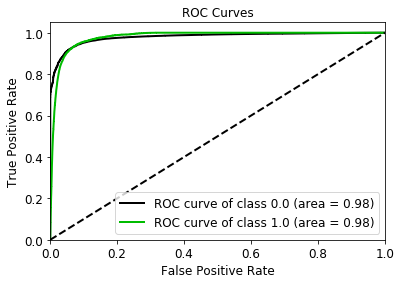

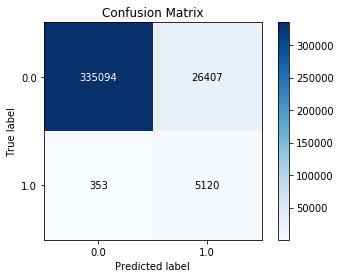

In [13]:
import scikitplot as skplt
import numpy as np
import matplotlib.pyplot as plt
import sklearn
np_test = np.asarray(test_y)
np_pred = np.asarray(pred_y)
np_prob = np.asarray(probas_y)
np_prob_2 = np.asarray(probas_y2)
roc=skplt.metrics.plot_roc(np_test, np_prob,plot_micro=False,plot_macro=False,
                         text_fontsize ='large')

fpr_1, tpr_1, thresholds_1 =sklearn.metrics.roc_curve(np_test, np_prob_2)

# plt.savefig('roc_inception_1_1_early.png', dpi=300)
conf=skplt.metrics.plot_confusion_matrix(np_test, np_pred)
# plt.savefig('conf_inception_1_2_early.png', dpi=300)
sklearn.metrics.auc(fpr_1, tpr_1)

In [18]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [19]:
from sklearn.metrics import roc_curve, auc
import pandas as pd
threshold = Find_Optimal_Cutoff(test_y, probas_y2)
print(threshold)

[0.5976767539978027]
